# SHAP 실습 (1)
### 성인 인구조사 데이터셋(Adult Census Income Dataset)
- 미국 인구 조사국 데이터를 기반
- 소득이 50,000달러를 초과하는지 여부를 예측하는 이진분류 문제

#### 주요 특징
- 연령(Age): 나이
- 직업 클래스(Workclass): 개인이 고용된 부문(예. Private, Self-emp-not-inc, Federal-gov 등)
- 학력(Education) 최종 학력 수준(예. Bachelors, Some-college 등)
- 혼인상태(Marital-status): 예.Married-civ-spouse, Divorced, Never-married 등
- 직업(Occupation): 예: Tech-support, Craft-repair, Other-service 등
- 관계(Relationship): 가족 내의 관계(예. Wife, Own-child, Husband 등)
- 인종(Race): 예. White, Asian-Pac-Islander, Amer-Indian-Eskimo 등
- 성별(Sex): Male, Famale
- 자본 이득(Capital-gain) 및 자본 손실(Capital-loss): 개인의 재산에서 발생한 이득과 손실
- 주당 근로 시간(Hours-per-week): 한 주에 일하는 시간
- 모국(Native-country): 태어난 국가

#### 타겟 변수
- 소득(Income): 개인의 소득이 연간 50,000 달러를 초과하는지 여부. <=50K 또는 >50K로 표시됨

In [ ]:
!pip install shap

In [ ]:
import shap
import sklearn

X_adult, y_adult = shap.datasets.adult()

# 로지스틱 회귀 모델 학습
model_adult = sklearn.linear_model.LogisticRegression(max_iter=10000) # 최대 반복 횟수 10000
model_adult.fit(X_adult, y_adult)

def model_adult_proba(x):
  return model_adult.predict_proba(x)[:,1]
def model_adult_log_odds(x): # 각 클래스에 대한 로그 확률 반환
  p = model_adult.predict_log_proba(x)
  return p[:, 1] - p[:,0]

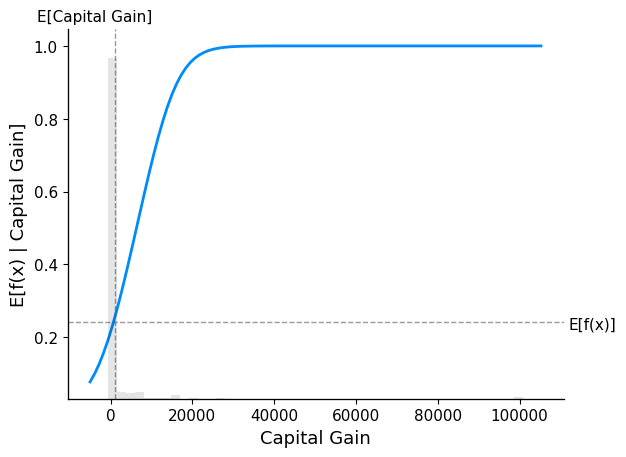

In [ ]:
# 부분 의존성 플롯 그리기
sample_ind = 18
fig, ax = shap.partial_dependence_plot(
    "Capital Gain", model_adult_proba, X_adult, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False
) # Capital Gain: 자본 이득 (증권, 선물계약과 옵션 등을 포함한 자본자산의 거래를 통한 매입가격과 매각가격의 차이에 의한 시세 차익)

- 개인의 자본 이득이 20000달러 이상이면, 소득이 50000달러가 넘는다고 해석할 수 있다.
- 20000달러 미만의 구역에서는 자본 이득에 따라 소득이 50000달러가 넘을 확률이 비례해서 증가

In [ ]:
# 입력 데이터 포인트들이 독립적임을 가정하고 SHAP 값 계산하기
backgroud_adult = shap.maskers.Independent(X_adult, max_samples=1000)
explainer = shap.Explainer(model_adult_proba, backgroud_adult)
shap_values_adult = explainer(X_adult[:1000])

PermutationExplainer explainer: 1001it [01:41,  9.34it/s]                          


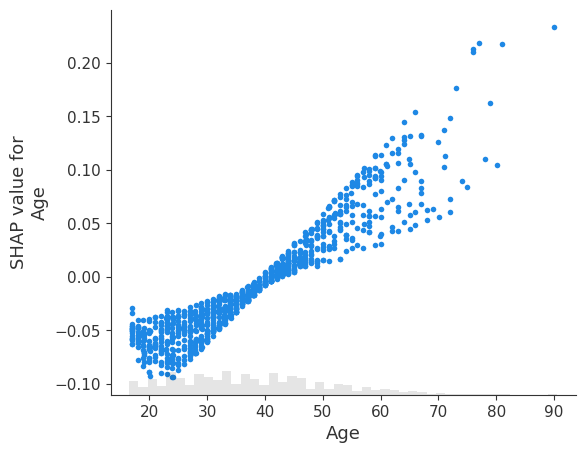

In [ ]:
# 산점도 형태로 Age 피처에 대한 Shap value 그래프 그리기
shap.plots.scatter(shap_values_adult[:,"Age"])

In [ ]:
# 모델의 로그 오즈 출력
explainer_log_odds = shap.Explainer(model_adult_log_odds, backgroud_adult)
shap_values_adult_log_odds = explainer_log_odds(X_adult[:1000])

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1458: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))
/usr/local/lib/python3.12/dist-packages/shap/explainers/_permutation.py:185: RuntimeWarning: invalid value encountered in scalar subtract
  row_values[ind] += outputs[i] - outputs[i + 1]
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1458: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))
/usr/local/lib/python3.12/dist-packages/shap/explainers/_permutation.py:179: RuntimeWarning: invalid value encountered in scalar subtract
  row_values[ind] += outputs[i + 1] - outputs[i]
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1458: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))
/usr/local/lib/python3.12/dist-packages/shap/explainers/_permutation.py:179: RuntimeWarning: invalid value encountered 

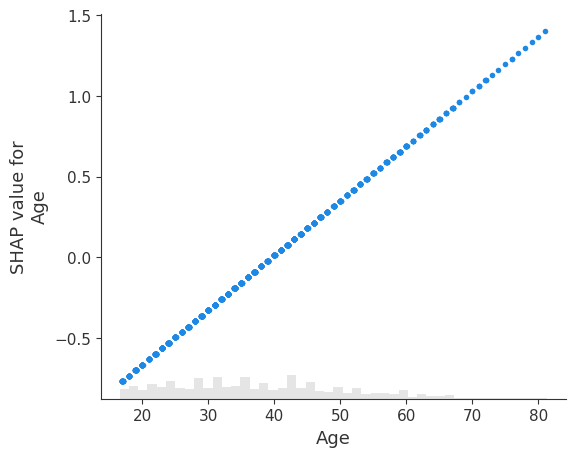

In [ ]:
shap.plots.scatter(shap_values_adult_log_odds[:,"Age"])

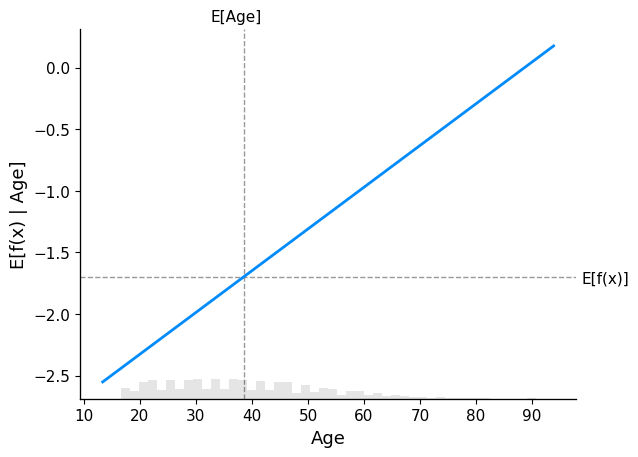

In [ ]:
# 부분 의존성 플롯으로 그려보기
fig, ax = shap.partial_dependence_plot(
    "Age", model_adult_log_odds, X_adult, model_expected_value=True,
    feature_expected_value=True, show=False, ice=False
)

로지스틱 회귀 모델에서는 로그 오즈를 통해 입력 특징의 해석을 간결하고 쉽게 할 수 있다.

## XGBoost 모델 설명하기

In [ ]:
import xgboost
model = xgboost.XGBClassifier(nestimators=100, max_depth=2).fit(X_adult, y_adult)

# shap value 계산
explainer = shap.Explainer(model, X_adult)
shap_values = explainer(X_adult)

shap_values.display_data = shap.datasets.adult(display=True)[0].values

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:53:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "nestimators" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
 98%|===================| 31786/32561 [00:27<00:00]       

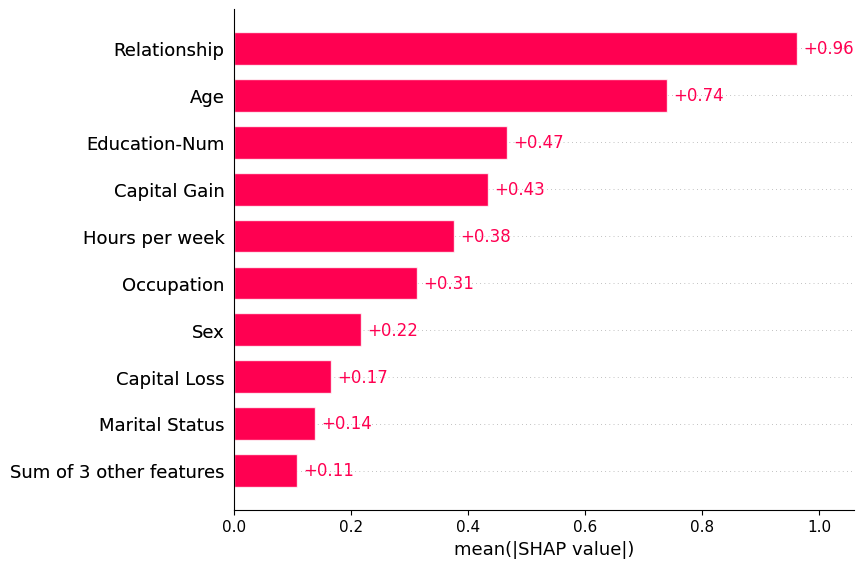

In [ ]:
shap.plots.bar(shap_values)

shap 막대그래프에는 데이터셋의 모든 행에 걸쳐 각 특성의 평균 절댓값을 계산하여 그림으로 표시

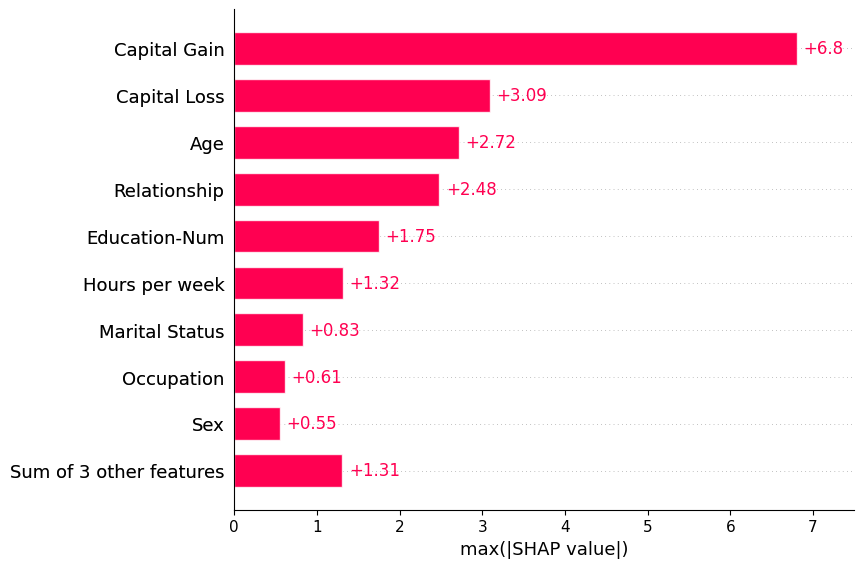

In [ ]:
shap.plots.bar(shap_values.abs.max(0)) # shap 값의 절댓값의 최댓값으로 지정

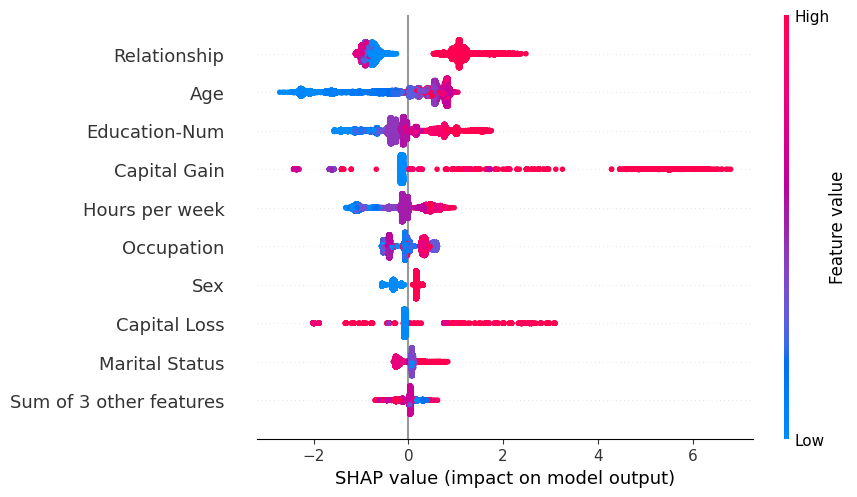

In [ ]:
shap.plots.beeswarm(shap_values) # beeswarm: 각 특성별로 shap 값의 전체 분포를 요약

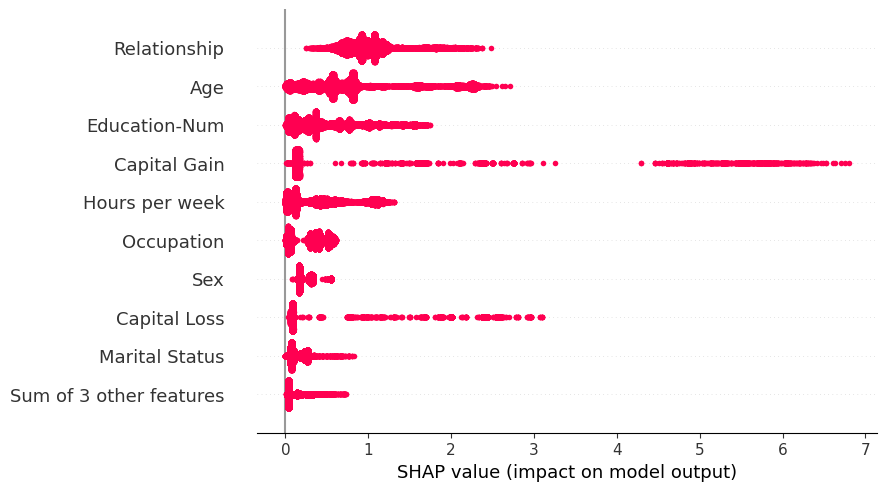

In [ ]:
# 절댓값 + 단색
shap.plots.beeswarm(shap_values.abs, color="shap_red")

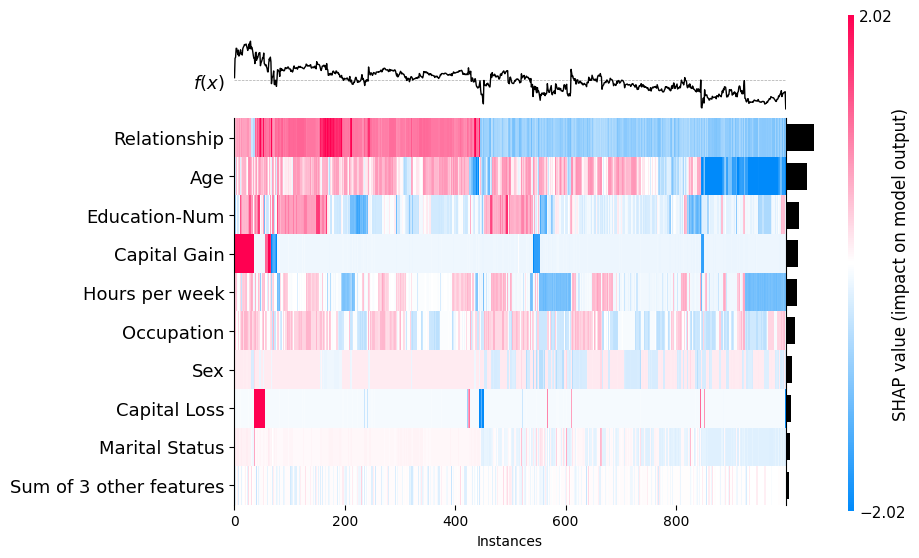

<Axes: xlabel='Instances'>

In [ ]:
# 처음 1000개의 데이터를 대상으로 히트맵 형태로 shap 값 도시
shap.plots.heatmap(shap_values[:1000])

- 인스턴스에 따라서 예측값의 결과와 각 피처별 shap 값을 표시
- 오른쪽 검정 막대: shap 값으로 계산한 특성 중요도

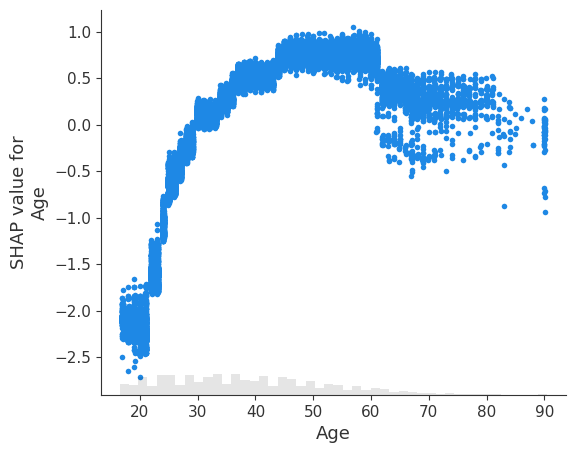

In [ ]:
shap.plots.scatter(shap_values[:, "Age"])

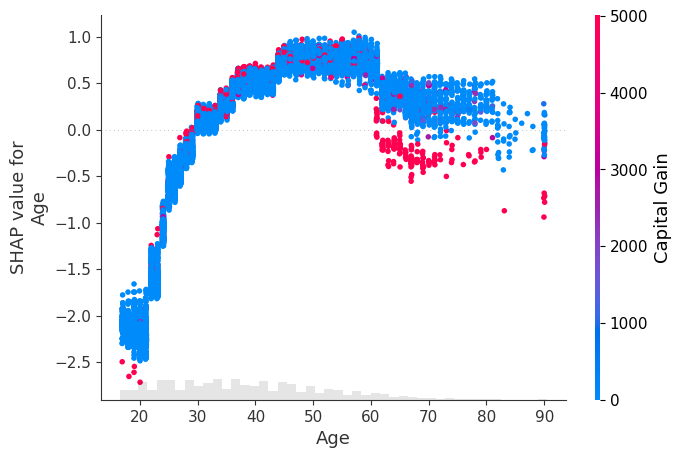

In [ ]:
# Capital gain의 shap 값에 따라 각 데이터 포인트의 색상을 지정
shap.plots.scatter(shap_values[:,"Age"], color=shap_values[:,"Capital Gain"])

- 60세 미만: 자본 이득과 나이 간의 상관 관계가 약간의 비례 관계
- 60세 이상: 두 특성 간의 관계가 뚜렷하지 않음
이렇게 산점도를 통해 두 특성의 상호작용을 시각화할 수 있다.

### Correlated features를 처리하기

In [ ]:
# 계층적 클러스터링 수행
clustering = shap.utils.hclust(X_adult, y_adult)

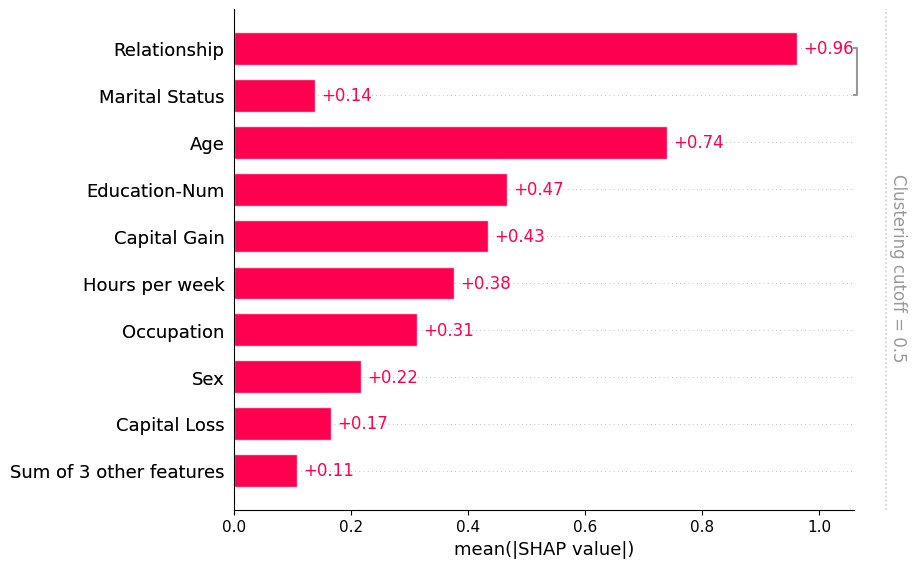

In [ ]:
shap.plots.bar(shap_values, clustering=clustering)

- 특성들이 클러스터별로 그룹화되어 표시된다. => 유사한 영향을 미치는 특성들을 함께 그룹화하여 더 명확하게 이해할 수 해준다.
- Relationship과 Marital Status가 유사한 그룹으로 클러스터링 되었다. => 가족 내에서의 관계와 결혼 여부가 연관이 있다

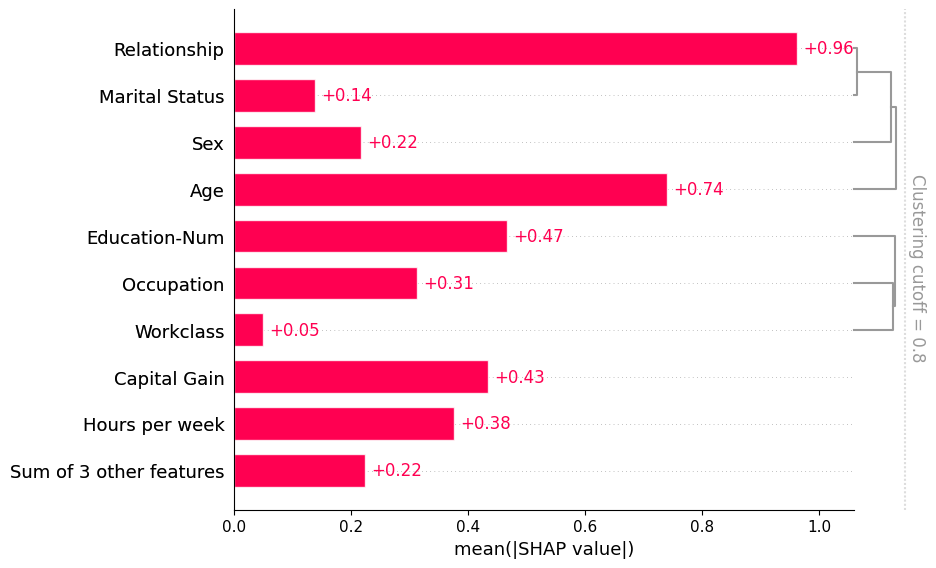

In [ ]:
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.8)

## Iris classification with scikit-learn

In [ ]:
# 데이터 불러오기
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import time

X_train, X_test, Y_train, Y_test = train_test_split(*shap.datasets.iris(),
                                                    test_size=0.2,
                                                    random_state=0)

# 정확도 출력함수
def print_accuracy(f):
  print("Accuracy = {0}%".format(100*np.sum(f(X_test) == Y_test)/len(Y_test)))
  time.sleep(0.5)

### K-nearest neighbors 모델 학습

In [ ]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(X_train, Y_train)

print_accuracy(knn.predict)

Accuracy = 96.66666666666667%


#### 테스트 데이터에서 특정 예측 결과 설명하기

In [ ]:
shap.initjs()

explainer = shap.KernelExplainer(knn.predict_proba, X_train)
shap_values = explainer.shap_values(X_test.iloc[0,:]) # 테스트 데이터 1개
shap.force_plot(explainer.expected_value[0], shap_values[:, 0], X_test.iloc[0, :]) # 0번 클래스에 대한 분석 진행

- 0번 클래스에 대한 평균적인 확률: 0.325
- 0번 데이터의 0번 클래스의 예측 확률: 0
- 각 특성별로 평균값인 0.325에서 0으로 예측 결과를 이동시키기 위해 한 역할을 볼 수 있다

#### 테스트 데이터의 모든 예측 설명하기

In [ ]:
shap.initjs()

shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test) # 0번 클래스에 대한 분석 진행

  0%|          | 0/30 [00:00<?, ?it/s]

- 하나의 샘플에 대한 force plot을 90도로 세워서 오른쪽으로 누적한 형태의 그림이다. (x축: 각각의 데이터, y축: 예측 결과)

#### Support vector machine with a linear kernal

In [ ]:
svc_linear = sklearn.svm.SVC(kernel="linear", probability=True)
svc_linear.fit(X_train, Y_train)
print_accuracy(svc_linear.predict)

Accuracy = 100.0%


In [ ]:
shap.initjs()

# 테스트 세트의 전체 예측을 설명하기
explainer = shap.KernelExplainer(svc_linear.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test)

  0%|          | 0/30 [00:00<?, ?it/s]

### Neural network

In [ ]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(
    solver="lbfgs", alpha=1e-1, hidden_layer_sizes=(5, 2), random_state=0
)
nn.fit(X_train, Y_train)
print_accuracy(nn.predict)

Accuracy = 100.0%


In [ ]:
shap.initjs()


explainer = shap.KernelExplainer(nn.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test)

  0%|          | 0/30 [00:00<?, ?it/s]